In [1]:
import xarray as xr
import numpy as np
%pylab inline
pylab.rcParams['figure.figsize'] = (18.0, 10.0); # Large figures

/glade/u/apps/ch/opt/pythonpkgs/2.7/xarray/0.9.5/intel/16.0.3/lib/python2.7/site-packages/xarray/core/formatting.py:16: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


Populating the interactive namespace from numpy and matplotlib


In [2]:
# gx3v7 output; daily averages
casename='C1850ECO.T62_g37.ciso.marbl_dev_levy'
rundir='/glade2/scratch2/mlevy/%s/run' % casename
date='0001-01-02'
filename = '%s/%s.pop.h.%s.nc' % (rundir, casename, date)
ds = xr.open_dataset(filename, decode_times=False, decode_coords=False)

# Uncomment to see original filename
# print filename

In [3]:
# Variables to keep in dataset
grid_vars = ['TLAT', 'TLONG', 'z_t', 'z_t_150m', 'z_w_bot', 'dz']
forcing_vars = ['ECOSYS_XKW', 'DUST_FLUX', 'SHF_QSW', 'TEMP', 'SALT', 'ECOSYS_ATM_PRESS',
                'ECOSYS_IFRAC', 'IRON_FLUX', 'NOx_FLUX', 'NHy_FLUX', 'ATM_CO2', 'ATM_ALT_CO2']
base_tracers = ['PO4', 'NO3', 'SiO3', 'NH4', 'Fe', 'Lig', 'O2', 'DIC', 'DIC_ALT_CO2', 'ALK', 'ALK_ALT_CO2',
                'DOC', 'DON', 'DOP', 'DOPr', 'DONr', 'DOCr', 'zooC', 'spChl', 'spC', 'spP', 'spFe', 'spCaCO3',
                'diatChl', 'diatC', 'diatP', 'diatFe', 'diatSi', 'diazChl', 'diazC', 'diazP', 'diazFe']
ciso_tracers = ['DI13C', 'DO13C', 'DI14C', 'DO14C', 'zoo13C', 'zoo14C', 'sp14C', 'sp14C',
                'spCa13CO3', 'spCa14CO3', 'diat13C', 'diat14c', 'diaz13C', 'diaz14C']
vars_to_keep = grid_vars + forcing_vars + base_tracers + ciso_tracers
# Pick an (i,j)
# (17,18) is Southern Ocean (28.1 E, 50.576 S); has 56 levels
# (19,50) is near SOFS site SW of Tasmania (143.3 E, 45.695 S); has 54 levels
lat_in = 19
lon_in = 50

raw_data = ds.isel(time=0, nlat=lat_in, nlon=lon_in).drop([v for v in ds.variables if v not in vars_to_keep])
raw_data.to_netcdf('raw_data.nc')

In [4]:
def pressure(depth):
    """
    ! !DESCRIPTION:
    !  This function computes pressure in bars from depth in meters
    !  using a mean density derived from depth-dependent global
    !  average temperatures and salinities from Levitus 1994, and
    !  integrating using hydrostatic balance.
    !
    !  References:
    !
    !     Levitus, S., R. Burgett, and T.P. Boyer, World Ocean Atlas
    !          1994, Volume 3: Salinity, NOAA Atlas NESDIS 3, US Dept. of
    !          Commerce, 1994.
    !
    !     Levitus, S. and T.P. Boyer, World Ocean Atlas 1994,
    !          Volume 4: Temperature, NOAA Atlas NESDIS 4, US Dept. of
    !          Commerce, 1994.
    !
    !     Dukowicz, J. K., 2000: Reduction of Pressure and Pressure
    !          Gradient Errors in Ocean Simulations, J. Phys. Oceanogr.,
    !          submitted.
    """
    # Taken from pressure() in POP's state_mod.F90
    # Note that this function returns value in units of atm rather than bars
    # [consistent with units of atmospheric pressure]
    return (0.059808*(exp(-0.025*depth) - 1.) + 0.100766*depth + 2.28405e-7*depth*depth)*101325./1e5

def xkw_to_u10sqr(xkw):
    # in marbl_diagnostics_mod.F90: diags(ind_diag%ECOSYS_XKW)%field_2d(:) = piston_velocity(:)
    # in marbl_mod.F90:             piston_velocity = xkw_coeff*u10_sqr(:)
    # in marbl_settings_mod.F90:    xkw_coeff =   6.97e-9_r8 ! in s/cm, from a = 0.251 cm/hr s^2/m^2 in Wannikhof 2014
    xkw_coeff = 6.97e-9 # s/cm
    return((xkw/xkw_coeff) * 0.0001) # convert from cm^2/s^2 -> m^2/s^2

def get_surface_value(single_col, column_var):
    # first just populate it with SHF_QSW(another scalar) to get all metadata
    new_ds = single_col['SHF_QSW'].copy(deep=True)
    new_ds.values = single_col[column_var].values[0]
    new_ds.attrs['long_name'] = single_col[column_var].attrs['long_name']
    new_ds.attrs['units'] = single_col[column_var].attrs['units']
    try:
        new_ds.encoding['scale_factor'] = single_col[column_var].encoding['scale_factor']
    except:
        pass
    return(new_ds)

# Copy raw data into new data structure
single_col = raw_data.copy(deep=True)

# unit conversion
# cm to m
for varname in ['z_t', 'z_t_150m', 'z_w_bot', 'dz']:
    single_col[varname].values *= 0.01
    single_col[varname].attrs['units'] = 'm'

# nmol/cm^2/s to mmol/m^2/s
for varname in ['NOx_FLUX', 'NHy_FLUX']:
    single_col[varname].values *= 0.01
    single_col[varname].attrs['units'] = 'mmol/m^2/s'

# g/cm^2/s to kg/m^2/s
for varname in ['DUST_FLUX']:
    single_col[varname].values *= 10.
    single_col[varname].attrs['units'] = 'kg/m^2/s'

# salinity units should be psu
single_col['SALT'].attrs['units'] = 'psu'

# Add SST, SSS, u10_sqr and pressure to dataset
single_col['SST'] = get_surface_value(single_col, 'TEMP')
single_col['SSS'] = get_surface_value(single_col, 'SALT')

# u10_sqr
varname = 'U10_SQR'
# first just populate it with SHF_QSW(another scalar) to get all metadata
single_col[varname] = single_col['SHF_QSW']
single_col[varname].values = xkw_to_u10sqr(single_col['ECOSYS_XKW'].values)
single_col[varname].attrs['long_name'] = '10m wind speed squared'
single_col[varname].attrs['units'] = 'm^2/s^2'

# pressure
varname = 'pressure'
# first just populate it with TEMP (another 1D var) to get all metadata
single_col[varname] = single_col['TEMP']
single_col[varname].values = np.where(np.isnan(single_col[varname].values),
                                      np.nan,
                                      pressure(single_col['z_t'].values))
single_col[varname].attrs['long_name'] = 'Pressure'
single_col[varname].attrs['units'] = 'atmospheres'

# Write to netcdf
single_col.to_netcdf('test.nc')

In [5]:
def update_xlim(interior_forcing):
    if interior_forcing == 'TEMP':
        plt.xlim(0, 13)
    if interior_forcing == 'SALT':
        plt.xlim(34, 35)
    if interior_forcing == 'pressure':
        plt.xlim(0,400)

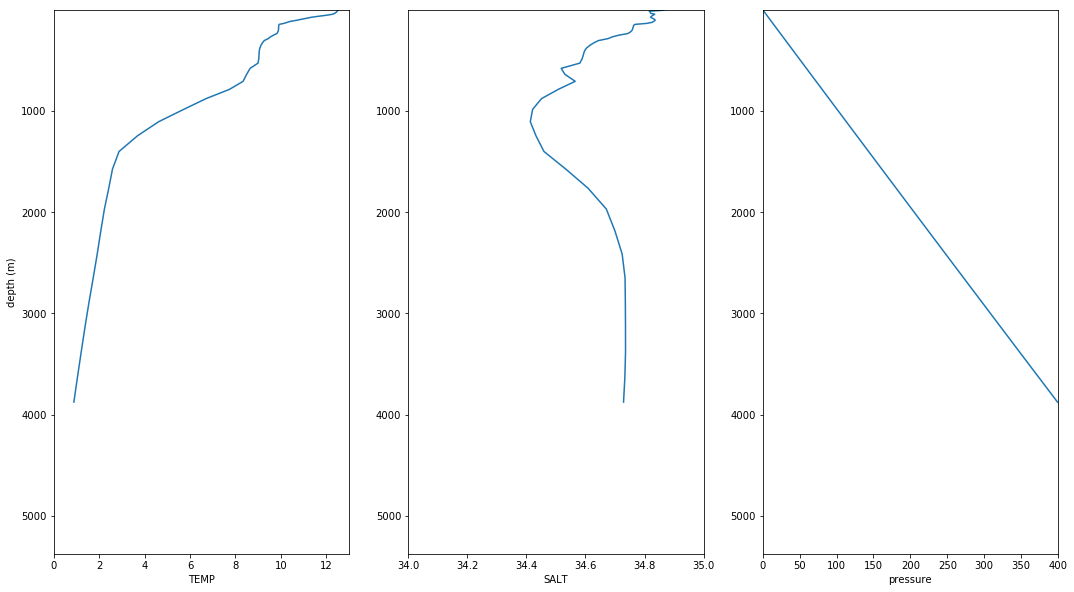

In [6]:
fig, axes = plt.subplots(ncols=3)
plt.xlim(400000,0)

for n, interior_forcing in enumerate(['TEMP', 'SALT', 'pressure']):
    single_col[interior_forcing].plot(ax=axes[n])
    plt.subplot(1,3,n+1);
    plt.plot(single_col[interior_forcing].values, single_col['z_t'].values);
    plt.ylim(max(single_col['z_t'].values), min(single_col['z_t'].values));
    plt.xlabel(interior_forcing)
    if n == 0:
        # Only want y-axis label on left-most plot
        plt.ylabel("depth (m)");
    update_xlim(interior_forcing);